<a href="https://colab.research.google.com/github/YASsMeN1997/Sentiment-Analysis-of-IMDB-Movie-Reviews/blob/main/Sentiment_Analysis_of_IMDB_Movie_Reviews_Using_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import re,string,unicodedata
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/NTI/week4/imdb reviews/IMDB Dataset.csv')

# Exploring Data

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Sentiment distribution')

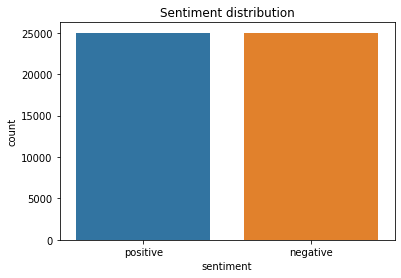

In [7]:
sns.countplot(df['sentiment'])
plt.title("Sentiment distribution")

In [8]:
# print first 5 reviews

for i in range(5):
  print("Review number ",[i],"\n")
  print(df['review'].iloc[i], "\n")
  print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review number  [0] 

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the s

In [9]:
# let's define function to count number of words in each review

def count_words(text):
  words = text.split()
  num_words = len(words)
  return num_words

In [10]:
df['word count'] = df['review'].apply(count_words)
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


Text(0.5, 1.0, 'Distrbution of negative reviews')

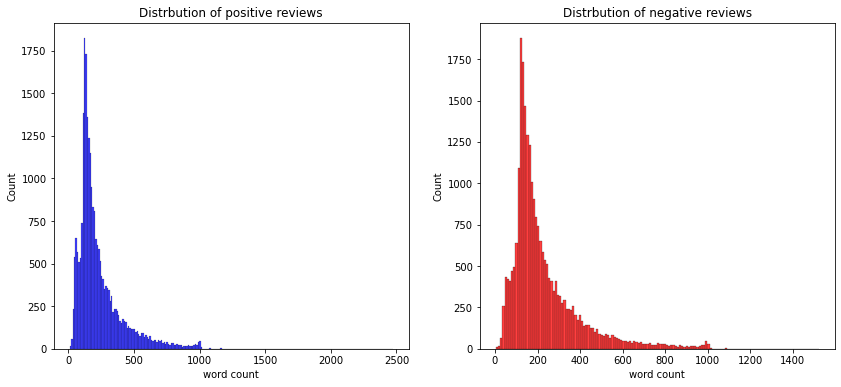

In [11]:
# let's see the number of words for each sentiment
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.histplot(df[df['sentiment'] == 'positive']['word count'], ax=ax[0], color='blue')
ax[0].set_title('Distrbution of positive reviews')
sns.histplot(df[df['sentiment'] == 'negative']['word count'], ax=ax[1], color='red')
ax[1].set_title('Distrbution of negative reviews')

- almost the same distrbution

# Preprocessing

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# encoding the sentiment
df.sentiment.replace("positive", 1, inplace=True)
df.sentiment.replace("negative", 0, inplace=True)

In [14]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [15]:
# define function to clean the reviews

def preprocess(text):
  soup = BeautifulSoup(text, "html.parser") #Removing the html strips
  text = soup.get_text()
  text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
  text = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", text, flags = re.MULTILINE)  #Removing emails 
  text = re.sub('\[[^]]*\]', '', text)  #Removing the square brackets
  text = re.sub(r'[^a-zA-z0-9\s]', '', text)  #Removing special character and keep only words and numbers
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]  #Removing stop words
  new_text = " ".join(filtered_text)
  ps = nltk.porter.PorterStemmer()  #Stemming the text
  new_text = ' '.join([ps.stem(word) for word in new_text.split()])
  return new_text


In [16]:
# check it
preprocess("hello mohamed how is all going on? beauty")

'hello moham go beauti'

In [17]:
# let's see duplicated reviews if any before preprocessing
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [18]:
# let's apply it on reviews
df.review = df['review'].apply(preprocess)

In [19]:
# check duplicated after preprocessing
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  420


In [20]:
# let's drop all duplicated reviews
df = df.drop_duplicates('review')

In [21]:
# let's count the words in each review again
df['new word count'] = df['review'].apply(count_words)


In [22]:
df.head()

,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,179
1,a wonder littl product the film techniqu unass...,1,162,91
2,i thought wonder way spend time hot summer wee...,1,166,92
3,basic there famili littl boy jake think there ...,0,138,71
4,petter mattei love time money visual stun film...,1,230,130


- we can see number of words is decreased

In [23]:
#word cloud for positive review words
pos_reviews =  df[df.sentiment == 1]
pos_reviews.head()


,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,179
1,a wonder littl product the film techniqu unass...,1,162,91
2,i thought wonder way spend time hot summer wee...,1,166,92
4,petter mattei love time money visual stun film...,1,230,130
5,probabl alltim favorit movi stori selfless sac...,1,119,63


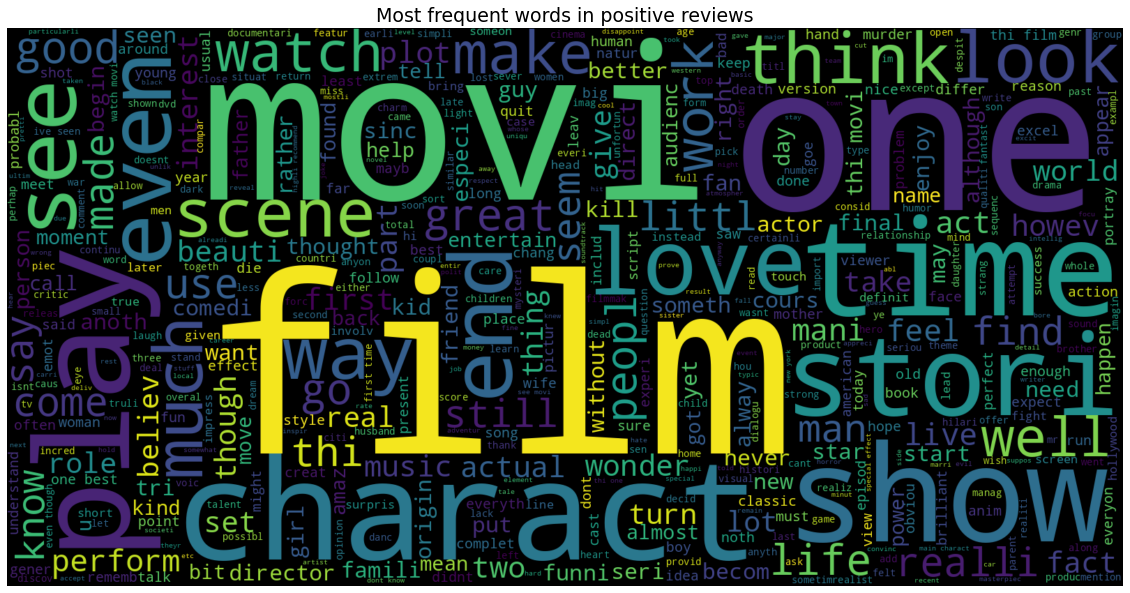

In [24]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [25]:
# print the first 10th most common words
from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(10)

[('i', 63690),
 ('film', 48837),
 ('movi', 42885),
 ('the', 38708),
 ('one', 26834),
 ('like', 19810),
 ('it', 17898),
 ('time', 15399),
 ('see', 14624),
 ('good', 14502)]

In [26]:
#word cloud for negitive review words
neg_reviews =  df[df.sentiment == 0]
neg_reviews.head()


,review,sentiment,word count,new word count
3,basic there famili littl boy jake think there ...,0,138,71
7,thi show amaz fresh innov idea 70 first air th...,0,174,93
8,encourag posit comment film i look forward wat...,0,130,68
10,phil alien one quirki film humour base around ...,0,96,53
11,i saw movi i 12 came i recal scariest scene bi...,0,180,96


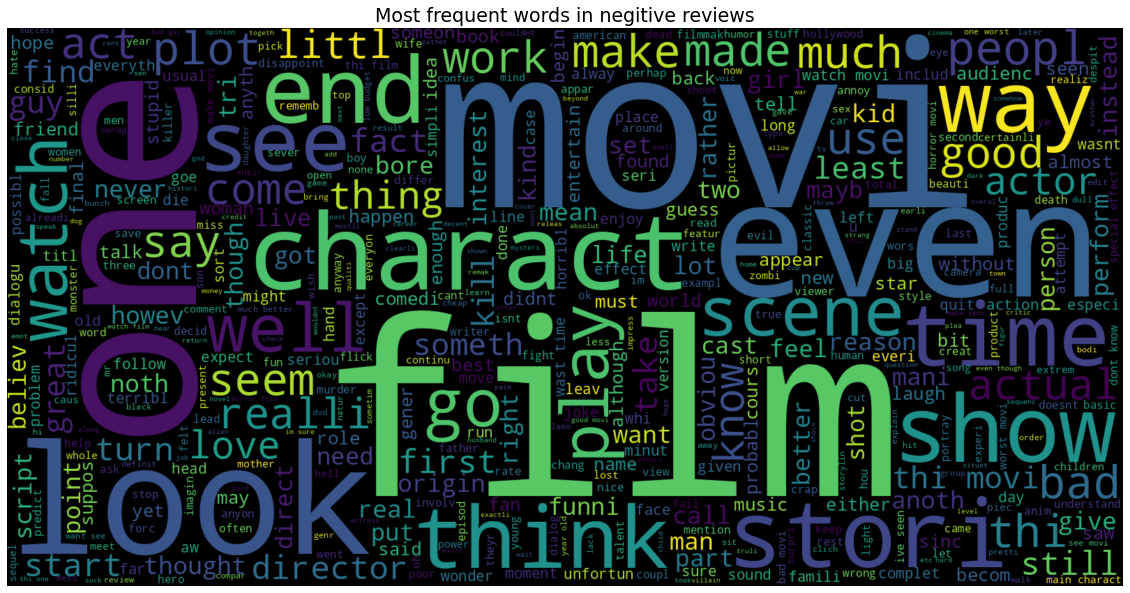

In [27]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negitive reviews', fontsize = 19)
plt.show()

In [28]:
# print the first 10th most common words
from collections import Counter
count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(10)

[('i', 71410),
 ('movi', 55292),
 ('film', 42590),
 ('the', 39187),
 ('one', 25415),
 ('like', 23646),
 ('it', 16299),
 ('make', 15264),
 ('get', 14969),
 ('even', 14933)]

## splitting data

In [29]:
X = df['review']
Y = df['sentiment']

In [30]:
# Term Frequency-Inverse Document Frequency model (TFIDF)
# It is used to convert text documents to matrix of tfidf features
vect = TfidfVectorizer()
X = vect.fit_transform(X)

In [31]:
X.shape

(49578, 181489)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [33]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34704, 181489)
Size of y_train:  (34704,)
Size of x_test:  (14874, 181489)
Size of y_test:  (14874,)


# Modeling & Evaluation



- We will try different machine learning algrothims

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [35]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
print("train score : ", lr.score(x_train, y_train))
print("test score : ", lr.score(x_test, y_test))
lr_pred = lr.predict(x_test)
lr_acc = accuracy_score(lr_pred, y_test)
print("Test accuracy: {:.2f}%".format(lr_acc*100))

train score :  0.9283656062701706
test score :  0.890883420734167
Test accuracy: 89.09%


In [36]:
lr_report=classification_report(y_test,lr_pred,target_names=['Positive','Negative'])
print(lr_report)

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      7395
    Negative       0.88      0.91      0.89      7479

    accuracy                           0.89     14874
   macro avg       0.89      0.89      0.89     14874
weighted avg       0.89      0.89      0.89     14874



In [37]:
def cm (y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Text(0.5, 1.0, 'Confusion matrix of Logistic Regression')

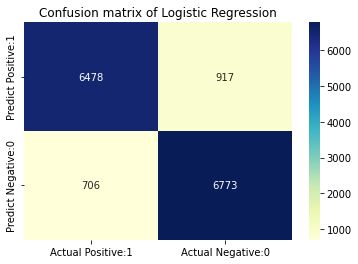

In [38]:
cm(y_test,lr_pred)
plt.title('Confusion matrix of Logistic Regression')

In [39]:
# Linear svm
lsvm = LinearSVC()
lsvm.fit(x_train, y_train)
print("train score : ", lsvm.score(x_train, y_train))
print("test score : ", lsvm.score(x_test, y_test))
lsvm_pred = lsvm.predict(x_test)
lsvm_acc = accuracy_score(lsvm_pred, y_test)
print("Test accuracy: {:.2f}%".format(lsvm_acc*100))

train score :  0.9871196403872753
test score :  0.8890681726502622
Test accuracy: 88.91%


In [40]:
lsvm_report=classification_report(y_test,lsvm_pred,target_names=['Positive','Negative'])
print(lsvm_report)

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      7395
    Negative       0.88      0.90      0.89      7479

    accuracy                           0.89     14874
   macro avg       0.89      0.89      0.89     14874
weighted avg       0.89      0.89      0.89     14874



Text(0.5, 1.0, 'Confusion matrix of LinearSVC')

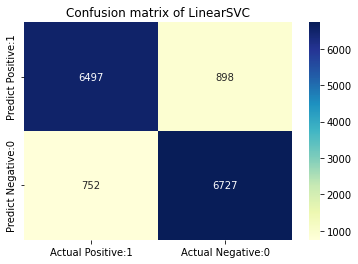

In [41]:
cm(y_test,lsvm_pred)
plt.title('Confusion matrix of LinearSVC')

In [42]:
# MultinomialNB
mn = MultinomialNB()
mn.fit(x_train, y_train)
print("train score : ", mn.score(x_train, y_train))
print("test score : ", mn.score(x_test, y_test))
mn_pred = mn.predict(x_test)
mn_acc = accuracy_score(mn_pred, y_test)
print("Test accuracy: {:.2f}%".format(mn_acc*100))

train score :  0.913324112494237
test score :  0.8607637488234503
Test accuracy: 86.08%


In [43]:
mn_report=classification_report(y_test,mn_pred,target_names=['Positive','Negative'])
print(mn_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      7395
    Negative       0.87      0.85      0.86      7479

    accuracy                           0.86     14874
   macro avg       0.86      0.86      0.86     14874
weighted avg       0.86      0.86      0.86     14874



Text(0.5, 1.0, 'Confusion matrix of MultinomialNB')

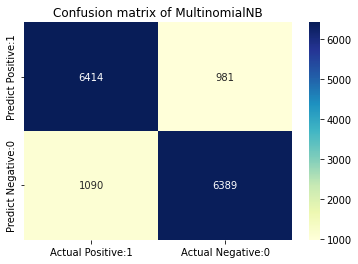

In [44]:
cm(y_test,mn_pred)
plt.title('Confusion matrix of MultinomialNB')

In [48]:
# DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print("train score : ", dt.score(x_train, y_train))
print("test score : ", dt.score(x_test, y_test))
dt_pred = dt.predict(x_test)
dt_acc = accuracy_score(dt_pred, y_test)
print("Test accuracy: {:.2f}%".format(dt_acc*100))

train score :  1.0
test score :  0.7118461745327417
Test accuracy: 71.18%


- overfitting !

In [50]:
# comparison betweem different ml algorithms
comp = {'Algorithm': ['Logistic Regression', 'MultinomialNB','LinearSVC','DecisionTreeClassifier'], 'Test Accuracy': [lr_acc, mn_acc,lsvm_acc,dt_acc]}
pd.DataFrame(data=comp)

,Algorithm,Test Accuracy
0,Logistic Regression,0.890883
1,MultinomialNB,0.860764
2,LinearSVC,0.889068
3,DecisionTreeClassifier,0.711846


- we can see Logistic Regression and LinearSVC give us the higher accuarcy 89%